# Figure 1

**Figure 1.** (a) Surface pressure (black contours, hPa), cloud cover, and precipitation at day 4.5 in the baroclinic life cycle simulation with ICON-NWP. Panel (b) shows cloud classes. The rectangles in both panels indicate the location of the domains for the LEM simulations.

---
@ Behrooz Keshtgar, KIT 2024

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib as mpl
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as mcolors
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


## 2- Loading datasets 

In [3]:
# Load post-precessed baroclinic life cycle simulation (remapped to 2.5 km grid resolution) 
ds = xr.open_mfdataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/NWP_blc_sim/icon-atm2d_ML_reg_20*.nc')
# deriving precipitation rate
ds['tot_prec_dt'] = ds['tot_prec'].diff(dim='time', label='upper') #mm/hr
# adjusting time coordinates
rng = pd.date_range('2022-01-01', periods=216, freq="1 H")
df = pd.DataFrame({ 'Date': rng })
t =  df.values[:,0]
ds.coords['time'] = t

## 3- Cloud classification

In [4]:
# The threshold for the cloud fraction to identify different cloud classes
thres=50

# function that gets 2-D cloud fraction data at High, Mid and Low level intervals and creates classes for the vertical column
def cloud_class(cc_data,thres):
    
    # CL1: H 
    # CL2: M 
    # CL3: L 
    # CL4: HM 
    # CL5: ML 
    # CL6: HL 
    # CL7: HML 
    # CL8: clear-sky
    
    # Create the vertical cloud classes based on the threshold (thres)
    
    cl1 = cc_data.where((cc_data.clch<thres) & (cc_data.clcm<thres) & (cc_data.clcl>thres)) # L
    cl1_num = cl1.where(xr.ufuncs.isnan(cl1.clch),other=1)
    cl1_num = cl1_num.where((xr.ufuncs.isnan(cl1_num.clch))==False,other=0)
    

    cl2 = cc_data.where((cc_data.clch<thres) & (cc_data.clcm>thres) & (cc_data.clcl<thres)) # M
    cl2_num = cl2.where(xr.ufuncs.isnan(cl2.clch),other=2)
    cl2_num = cl2_num.where((xr.ufuncs.isnan(cl2_num.clch))==False,other=0)


    cl3     = cc_data.where((cc_data.clch>thres) & (cc_data.clcm<thres) & (cc_data.clcl<thres)) # H
    cl3_num = cl3.where(xr.ufuncs.isnan(cl3.clch),other=3)
    cl3_num = cl3_num.where((xr.ufuncs.isnan(cl3_num.clch))==False,other=0)
    
    
    cl4 = cc_data.where((cc_data.clch<thres) & (cc_data.clcm>thres) & (cc_data.clcl>thres)) # ML
    cl4_num = cl4.where(xr.ufuncs.isnan(cl4.clch),other=4)
    cl4_num = cl4_num.where((xr.ufuncs.isnan(cl4_num.clch))==False,other=0)

    
    cl5 = cc_data.where((cc_data.clch>thres) & (cc_data.clcm>thres) & (cc_data.clcl<thres)) # HM
    cl5_num = cl5.where(xr.ufuncs.isnan(cl5.clch),other=5)
    cl5_num = cl5_num.where((xr.ufuncs.isnan(cl5_num.clch))==False,other=0)
    

    cl6 = cc_data.where((cc_data.clch>thres) & (cc_data.clcm<thres) & (cc_data.clcl>thres)) # HL
    cl6_num = cl6.where(xr.ufuncs.isnan(cl6.clch),other=6)
    cl6_num = cl6_num.where((xr.ufuncs.isnan(cl6_num.clch))==False,other=0)

    
    cl7 = cc_data.where((cc_data.clch>thres) & (cc_data.clcm>thres) & (cc_data.clcl>thres)) # HML
    cl7_num = cl7.where(xr.ufuncs.isnan(cl7.clch),other=7)
    cl7_num = cl7_num.where((xr.ufuncs.isnan(cl7_num.clch))==False,other=0)

    
    cl8 = cc_data.where((cc_data.clch<thres) & (cc_data.clcm<thres) & (cc_data.clcl<thres)) # clear-sky
    cl8_num = cl8.where(xr.ufuncs.isnan(cl8.clch),other=8)
    cl8_num = cl8_num.where((xr.ufuncs.isnan(cl8_num.clch))==False,other=0)

    # we sum all the classes to one array to make a mask for the entire domain based on the cloud classification
    cloud_class_mask   = cl1+cl2+cl3+cl4+cl5+cl6+cl7+cl8 
    cloud_class_number = cl1_num+cl2_num+cl3_num+cl4_num+cl5_num+cl6_num+cl7_num+cl8_num
    
    return cloud_class_number #,cloud_class_mask


cloud_class_num = cloud_class(ds[['clcm','clch','clcl']].sel(time='2022-01-05T12:00:00.000000000'),thres)
    
A = cloud_class_num.clcm.squeeze().values

bounds = np.linspace(np.nanmin(A), int(np.nanmax(A))+1, int(np.nanmax(A))+1)
cbar_lbls = ['Low','Middle','High','Middle-Low','High-Middle','High-Low','High-Middle-Low','Clear-sky']

# creating a colorbar to distinguish between cloud classes
cmapb = cm.Blues(np.linspace(0.3,0.8,3))
cmapr = cm.Reds(np.linspace(0.2,1,5))
cmapt = np.concatenate((cmapb, cmapr), axis=0)
cmapt[7] = np.array([0,0,0,0])
cmapt[5] = np.array([0.6, 0.6, 0.6, 1.]) #Gray

cmap2 = mcolors.ListedColormap(cmapt)
norm = mpl.colors.BoundaryNorm(bounds, cmap2.N)

### For data publication

In [16]:
# Variables required for the plot
prec_rate   = ds['tot_prec_dt'].sel(time='2022-01-05T12:00:00.000000000')
pres_sfc    = ds['pres_sfc'].sel(time='2022-01-05T12:00:00.000000000')/100 # Pa -> hPa
cloud_cover = ds['clct'].sel(time='2022-01-05T12:00:00.000000000')
cloud_class = cloud_class_num['clcm'].squeeze()
lon = ds['lon']-38
lat = ds['lat']

# creating a dataset and save for data publication
ds_out = xr.Dataset(
    data_vars={
        "prec_rate"  : (prec_rate.dims, prec_rate.data),
        "pres_sfc"   : (pres_sfc.dims, pres_sfc.data),
        "cloud_cover": (cloud_cover.dims, cloud_cover.data),
        "cloud_class": (cloud_class.dims, cloud_class.data),
    },
    coords={"lat": (["lat"], lat), 
            "lon": (["lon"], lon)})

ds_out.attrs['description'] = 'precipitation rate, cloud cover, surface pressure and cloud classes at day 4.5 of NWP baroclinic life cycle simulation'
ds_out.to_netcdf('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure1.nc')

In [5]:
ds_out = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure1.nc')

## 4- Plot

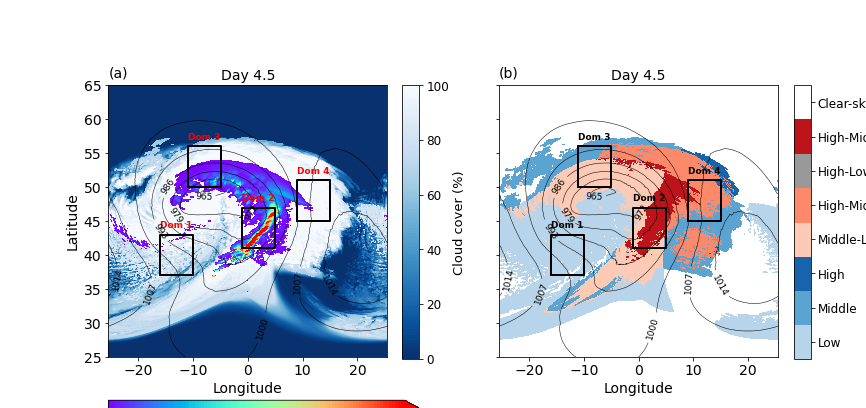

In [10]:
lat = ds_out['lat']
lon = ds_out['lon']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
i = 0
# position of the LES domains
a1 = np.array([-16,-10,-10,-16,-16])
b1 = np.array([37,37,43,43,37])

a2 = np.array([-11,-5,-5,-11,-11])
b2 = np.array([50,50,56,56,50])

a3 = np.array([-1,5,5,-1,-1])
b3 = np.array([41,41,47,47,41])

a4 = np.array([9,15,15,9,9])
b4 = np.array([45,45,51,51,45])

for ax in axes.flat:
    
    ax.tick_params(labelsize=14)
    ax.set_ylim([25,65])
        
    if i == 0:
        ax.set_title('Day 4.5', fontsize=14)
        
        # cloud cover contourf
        im1=ax.contourf(lon,lat,ds_out['cloud_cover'],cmap=plt.cm.get_cmap('Blues_r'),levels=np.arange(0.0,101,1))
        cbaxes1 = fig.add_axes([0.465, 0.12, 0.02, 0.76]) 
        cbar1 = fig.colorbar(im1, ax=ax,orientation='vertical',cax = cbaxes1,ticks=np.arange(0,120,20))
        cbar1.set_label(label='Cloud cover (%)', size='13')
        cbar1.ax.tick_params(labelsize=12)
        
        # surface pressure contours
        cs=ax.contour(lon,lat,ds_out['pres_sfc'],colors='k',linewidths=0.5,levels=np.arange(930,1027,7))
        plt.clabel(cs, inline=5, fontsize=9,fmt='%1.f')

        # precipitation rate contourf
        im2 = ax.contourf(lon,lat,ds_out['prec_rate'],levels=np.arange(0.1,10.1,0.1),cmap='rainbow',extend='max') 
        cbaxes2 = fig.add_axes([0.125, -0.04, 0.36, 0.045]) 
        cbar2 = fig.colorbar(im2, ax=ax,orientation='horizontal',cax = cbaxes2,ticks=[0.1,1,2,3,4,5,6,7,8,9,10])
        cbar2.set_label(label='Precipitation rate (mm hr$^{-1}$)', size='13')
        cbar2.ax.tick_params(labelsize=12)


        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        
        ax.plot(a1,b1,color='k',linewidth=2)
        ax.plot(a2,b2,color='k',linewidth=2)
        ax.plot(a3,b3,color='k',linewidth=2)
        ax.plot(a4,b4,color='k',linewidth=2)
        
        ax.text(-16,44, 'Dom 1', fontsize=8,size=9,fontweight='bold',color='r')
        ax.text(-1,48, 'Dom 2', fontsize=8,size=9,fontweight='bold',color='r')
        ax.text(-11,57, 'Dom 3', fontsize=8,size=9,fontweight='bold',color='r')
        ax.text(9,52, 'Dom 4', fontsize=8,size=9,fontweight='bold',color='r')
        
        ax.text(0.0, 1.03, '(a)', transform=ax.transAxes, 
            size=14)
        
    if i == 1:
        ax.set_title('Day 4.5', fontsize=14)
        
        # surface pressure contours
        cs=ax.contour(lon,lat,ds_out['pres_sfc'],colors='k',linewidths=0.5,levels=np.arange(930,1027,7))
        plt.clabel(cs, inline=5, fontsize=9,fmt='%1.f')
        
        # cloud classes
        im3 = ax.pcolormesh(lon,lat,ds_out['cloud_class'].values,cmap=cmap2,norm=norm)
        ax.set_yticklabels([])
        
        ax.set_xlabel('Longitude',fontsize=14)
        
        ax.plot(a1,b1,color='k',linewidth=2)
        ax.plot(a2,b2,color='k',linewidth=2)
        ax.plot(a3,b3,color='k',linewidth=2)
        ax.plot(a4,b4,color='k',linewidth=2)
        
        
        ax.text(-16,44, 'Dom 1', fontsize=8,size=9,fontweight='bold',color='k')
        ax.text(-1,48, 'Dom 2', fontsize=8,size=9,fontweight='bold',color='k')
        ax.text(-11,57, 'Dom 3', fontsize=8,size=9,fontweight='bold',color='k')
        ax.text(9,52, 'Dom 4', fontsize=8,size=9,fontweight='bold',color='k')
        
        ax.text(0.0, 1.03, '(b)', transform=ax.transAxes, 
            size=14)    
        
    i = i + 1
      
fig.subplots_adjust(wspace=0.4)    
    
cb_ax1 = fig.add_axes([0.918, 0.12, 0.02, 0.76]) # xcenter/ycenter/width/height
cbar1 = fig.colorbar(im3,cax=cb_ax1,orientation='vertical',shrink=0.95)
cbar1.set_ticklabels(cbar_lbls)
minorticks = np.arange(0.5, 10, 1)
cbar1.set_ticks(minorticks)
cbar1.ax.tick_params(labelsize=12) 

plt.savefig('figure1.pdf', format='pdf', bbox_inches='tight', dpi=100, compression=9)
#plt.savefig('figure1.png', bbox_inches = 'tight',dpi=300)